**Learning to Walk**

In [ ]:
# This code is based on PhilTabor's implemntation of TD3 [https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/TD3/td3_torch.py]
# and an implementation of Honghao Wei and Lei Ying's paper FORK: A FORward-looKing Actor for Model-Free Reinforcement Learning

%%capture
!pip install 'gym[box2d]'
!apt update
!apt install xvfb -y
!pip install pyvirtualdisplay

import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
from pyvirtualdisplay import Display
from IPython import display as disp
%matplotlib inline
import copy

display = Display(visible=0,size=(600,600))
display.start()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

plot_interval = 10 # update the plot every N episodes
video_every = 50 # videos can take a very long time to render so only do it every N episodes

Create an Agent

In [ ]:
# TD3 Implementation
import os

class Agent():
	def __init__(self, alpha, beta, input_shape, n_actions, tau,  env, name,
				gamma=0.99, update_actor_every=2, layer_1_dims=400,
				layer_2_dims=300, noise=0.1, memory_size=1000000, batch_size=100,
			 	warmup=1000):

		# max and min actions for noise
		self.max_action = env.action_space.high
		self.min_action = env.action_space.low
		self.n_actions = n_actions

		self.noise = noise
		self.gamma = gamma
		self.update_actor_every = update_actor_every
		self.tau = tau
		self.batch_size = batch_size
		self.warmup = warmup

		# Time steps for learning and performinf action
		self.learn_step = 0
		self.time_step = 0

		self.critic_1 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "critic_1", "saves/"+name)
		self.critic_2 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "critic_2", "saves/"+name)
		self.actor = ActorNetwork(alpha, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "actor", "saves/"+name)

		self.target_critic_1 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
		 								n_actions, "target_critic_1", "saves/"+name)
		self.target_critic_2 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "target_critic_2", "saves/"+name)
		self.target_actor = ActorNetwork(alpha, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "target_actor", "saves/"+name)

		self.memory = ReplayBuffer(memory_size, input_shape, n_actions)

		self.update_target_network_parameters(tau=1)

	def update_target_network_parameters(self, tau=None):
		if tau is None:
			tau = self.tau

		actor_params = self.actor.named_parameters()
		critic_1_params = self.critic_1.named_parameters()
		critic_2_params = self.critic_2.named_parameters()
		target_actor_params = self.target_actor.named_parameters()
		target_critic_1_params = self.target_critic_1.named_parameters()
		target_critic_2_params = self.target_critic_2.named_parameters()

		actor_dict = dict(actor_params)
		critic_1_dict = dict(critic_1_params)
		critic_2_dict = dict(critic_2_params)
		target_actor_dict = dict(target_actor_params)
		target_critic_1_dict = dict(target_critic_1_params)
		target_critic_2_dict = dict(target_critic_2_params)

		for name in target_actor_dict:
			target_actor_dict[name] = tau*actor_dict[name].clone() + \
				(1-tau)*target_actor_dict[name].clone()

		for name in target_critic_1_dict:
			target_critic_1_dict[name] = tau*critic_1_dict[name].clone() + \
				(1-tau)*target_critic_1_dict[name].clone()

		for name in target_critic_2_dict:
			target_critic_2_dict[name] = tau*critic_2_dict[name].clone() + \
				(1-tau)*target_critic_2_dict[name].clone()

		self.target_actor.load_state_dict(target_actor_dict)
		self.target_critic_1.load_state_dict(target_critic_1_dict)
		self.target_critic_2.load_state_dict(target_critic_2_dict)

	def choose_action(self, observation):
		if self.time_step < self.warmup:
			mu = torch.tensor(np.random.normal(scale=self.noise, size=(self.n_actions,)))
		else:
			state = torch.tensor(observation, dtype=torch.float).to(self.actor.device)
			mu = self.actor.forward(state).to(self.actor.device)

		action = mu + torch.tensor(np.random.normal(scale=self.noise), dtype=torch.float).to(self.actor.device)
		action = torch.clamp(action, self.min_action[0], self.max_action[0])

		self.time_step += 1

		return action.cpu().detach().numpy()

	def store_memory(self, state, new_state, action, reward, done):
		self.memory.store_transition(state, new_state, action, reward, done)

	def learn(self):
		if self.memory.memory_centre < self.batch_size:
			return

		state, new_state, action, reward, done = self.memory.sample_buffer(self.batch_size)

		#All devices same so device type dosent matter here
		state = torch.tensor(state, dtype=torch.float).to(self.actor.device)
		new_state = torch.tensor(new_state, dtype=torch.float).to(self.actor.device)
		action = torch.tensor(action, dtype=torch.float).to(self.actor.device)
		reward = torch.tensor(reward, dtype=torch.float).to(self.actor.device)
		done = torch.tensor(done).to(self.actor.device)

		target_action = self.target_actor.forward(new_state)
		target_action = target_action + torch.clamp(torch.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
		target_action = torch.clamp(target_action, self.min_action[0], self.max_action[0])

		_q1 = self.target_critic_1.forward(new_state, target_action)
		_q2 = self.target_critic_2.forward(new_state, target_action)

		_q1[done] = 0.0
		_q2[done] = 0.0

		_q1 = _q1.view(-1)
		_q2 = _q2.view(-1)

		q1 = self.critic_1.forward(state, action)
		q2 = self.critic_2.forward(state, action)

		target = reward + self.gamma * torch.min(_q2, _q1)
		target = target.view(self.batch_size, 1)

		self.critic_1.optimizer.zero_grad()
		self.critic_2.optimizer.zero_grad()

		q1_loss = F.mse_loss(target, q1)
		q2_loss = F.mse_loss(target, q2)
		critic_loss = q1_loss + q2_loss
		critic_loss.backward()

		self.critic_1.optimizer.step()
		self.critic_2.optimizer.step()

		self.learn_step += 1

		if self.learn_step % self.update_actor_every == 0:
			# Update Actor network and target networks
			self.actor.optimizer.zero_grad()
			actor_loss = self.critic_1.forward(state, self.actor.forward(state))
			actor_loss = -torch.mean(actor_loss)
			actor_loss.backward()
			self.actor.optimizer.step()

			self.update_target_network_parameters()

	def save(self):
		print("---Saving---")
		self.actor.save_checkpoint()
		self.critic_1.save_checkpoint()
		self.critic_2.save_checkpoint()
		self.target_actor.save_checkpoint()
		self.target_critic_1.save_checkpoint()
		self.target_critic_2.save_checkpoint()

	def load(self):
		print("---Loading---")
		self.actor.load_checkpoint()
		self.critic_1.load_checkpoint()
		self.critic_2.load_checkpoint()
		self.target_actor.load_checkpoint()
		self.target_critic_1.load_checkpoint()
		self.target_critic_2.load_checkpoint()

	def get_device(self):
		return self.actor.device


class ActorNetwork(nn.Module):
	def __init__(self, lr, fc1_dims, fc2_dims, input_shape, n_actions, name, chkp_dir):
		super(ActorNetwork, self).__init__()

		self.full_conn1 = nn.Linear(*input_shape, fc1_dims)
		self.full_conn2 = nn.Linear(fc1_dims, fc2_dims)
		self.output = nn.Linear(fc2_dims, n_actions)

		self.chkp_file = os.path.join(chkp_dir, name)

		self.optimizer = optim.Adam(self.parameters(), lr=lr)

		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		self.to(self.device)

	def forward(self, state):
		action = self.full_conn1(state)
		action = F.relu(action)
		action = self.full_conn2(action)
		action = F.relu(action)
		action = self.output(action)
		action = torch.tanh(action)
		return action

	def save_checkpoint(self):
		torch.save(self.state_dict(), self.chkp_file)

	def load_checkpoint(self):
		self.load_state_dict(torch.load(self.chkp_file, map_location=self.device))


class CriticNetwork(nn.Module):
	def __init__(self, lr, fc1_dims, fc2_dims, state_shape, n_actions, name, chkp_dir):
		super(CriticNetwork, self).__init__()

		self.full_conn1 = nn.Linear(state_shape[0]+n_actions, fc1_dims)
		self.full_conn2 = nn.Linear(fc1_dims, fc2_dims)
		self.output = nn.Linear(fc2_dims, 1)

		self.chkp_file = os.path.join(chkp_dir, name)

		self.optimizer = optim.Adam(self.parameters(), lr=lr)

		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		self.to(self.device)

	def forward(self, state, action):
		q = self.full_conn1(torch.cat([state, action], dim=1))
		q = F.relu(q)
		q = self.full_conn2(q)
		q = F.relu(q)
		q = self.output(q)

		return q

	def save_checkpoint(self):
		torch.save(self.state_dict(), self.chkp_file)

	def load_checkpoint(self):
		self.load_state_dict(torch.load(self.chkp_file, map_location=self.device))


class ReplayBuffer():
	def __init__(self, memory_size, input_shape, n_actions):
		self.memory_size = memory_size
		self.memory_centre = 0
		self.state_memory = np.zeros((self.memory_size, *input_shape))
		self.new_state_memory = np.zeros((self.memory_size, *input_shape))
		self.action_memory = np.zeros((self.memory_size, n_actions))
		self.reward_memory = np.zeros(self.memory_size)
		self.terminal_memory = np.zeros(self.memory_size, dtype=np.bool)

	def store_transition(self, state, action, reward, new_state, done):
		index = self.memory_centre % self.memory_size
		self.state_memory[index] = state
		self.new_state_memory[index] = new_state
		self.action_memory[index] = action
		self.reward_memory[index] = reward
		self.terminal_memory[index] = done
		self.memory_centre += 1

	def sample_buffer(self, batch_size):
		max_memory = min(self.memory_size, self.memory_centre)
		batch = np.random.choice(max_memory, batch_size)

		states = self.state_memory[batch]
		new_states = self.new_state_memory[batch]
		actions = self.action_memory[batch]
		rewards = self.reward_memory[batch]
		terminal = self.terminal_memory[batch]

		return states, new_states, actions, rewards, terminal

In [ ]:
# TD3 FORK modification 
import os

class Agent():
	def __init__(self, alpha, beta, delta, input_shape, n_actions, tau,  env, name,
				sys_weight, sys_weight2, sys_threshold, gamma=0.99, update_actor_every=2,
                layer_1_dims=400, layer_2_dims=300, noise=0.1, memory_size=1000000,
                batch_size=100, warmup=1000):

		# max and min actions for noise
		self.max_action = env.action_space.high
		self.min_action = env.action_space.low
		self.n_actions = n_actions

        # state space bounds
		self.obs_lower_bound = float(env.observation_space.low[0])
		self.obs_upper_bound = float(env.observation_space.high[0])
		if self.obs_upper_bound == float('inf'):
			self.obs_upper_bound, self.obs_lower_bound = 0, 0

		self.rew_lower_bound = 0
		self.rew_upper_bound = 0

		self.noise = noise
		self.gamma = gamma
		self.update_actor_every = update_actor_every
		self.tau = tau
		self.batch_size = batch_size
		self.warmup = warmup

		# weights for system components off FORK
		self.sys_weight = sys_weight
		self.sys_weight2 = sys_weight2
		self.sys_threshold = sys_threshold

		# Time steps for learning and performinf action
		self.learn_step = 0
		self.time_step = 0

		self.critic_1 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "critic_1", "saves/"+name)
		self.critic_2 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "critic_2", "saves/"+name)
		self.actor = ActorNetwork(alpha, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "actor", "saves/"+name)

		self.target_critic_1 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "target_critic_1", "saves/"+name)
		self.target_critic_2 = CriticNetwork(beta, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "target_critic_2", "saves/"+name)
		self.target_actor = ActorNetwork(alpha, layer_1_dims, layer_2_dims, input_shape,
										n_actions, "target_actor", "saves/"+name)

		# Give the system components lr delta, gamma was taken by discount :(
		self.system = SystemNetwork(delta, layer_1_dims, layer_2_dims, input_shape,
									n_actions, "system", "saves/"+name)
		self.system.apply(self.init_sys_weights)

		self.sys_rew = SystemReward(delta, layer_1_dims, layer_2_dims, input_shape,
									n_actions, "sysreward", "saves/"+name)

		self.memory = ReplayBuffer(memory_size, input_shape, n_actions)

		self.update_target_network_parameters(tau=1)

	def init_sys_weights(self, model):
		if type(model) == nn.Linear:
			# Glorot / Xavier initialisation
			torch.nn.init.xavier_uniform(model.weight)
			model.bias.data.fill_(0.001)
    
	def update_target_network_parameters(self, tau=None):
		if tau is None:
			tau = self.tau

		actor_params = self.actor.named_parameters()
		critic_1_params = self.critic_1.named_parameters()
		critic_2_params = self.critic_2.named_parameters()
		target_actor_params = self.target_actor.named_parameters()
		target_critic_1_params = self.target_critic_1.named_parameters()
		target_critic_2_params = self.target_critic_2.named_parameters()

		actor_dict = dict(actor_params)
		critic_1_dict = dict(critic_1_params)
		critic_2_dict = dict(critic_2_params)
		target_actor_dict = dict(target_actor_params)
		target_critic_1_dict = dict(target_critic_1_params)
		target_critic_2_dict = dict(target_critic_2_params)

		for name in target_actor_dict:
			target_actor_dict[name] = tau*actor_dict[name].clone() + \
				(1-tau)*target_actor_dict[name].clone()

		for name in target_critic_1_dict:
			target_critic_1_dict[name] = tau*critic_1_dict[name].clone() + \
				(1-tau)*target_critic_1_dict[name].clone()

		for name in target_critic_2_dict:
			target_critic_2_dict[name] = tau*critic_2_dict[name].clone() + \
				(1-tau)*target_critic_2_dict[name].clone()

		self.target_actor.load_state_dict(target_actor_dict)
		self.target_critic_1.load_state_dict(target_critic_1_dict)
		self.target_critic_2.load_state_dict(target_critic_2_dict)

	def choose_action(self, observation):
		if self.time_step < self.warmup:
			mu = torch.tensor(np.random.normal(scale=self.noise, size=(self.n_actions,)))
		else:
			state = torch.tensor(observation, dtype=torch.float).to(self.actor.device)
			mu = self.actor.forward(state).to(self.actor.device)

		action = mu + torch.tensor(np.random.normal(scale=self.noise), dtype=torch.float).to(self.actor.device)
		action = torch.clamp(action, self.min_action[0], self.max_action[0])

		self.time_step += 1

		return action.cpu().detach().numpy()

	def store_memory(self, state, new_state, action, reward, done):
		self.memory.store_transition(state, new_state, action, reward, done)

	def learn(self):
		if self.memory.memory_centre < self.batch_size:
			return

		state, new_state, action, reward, done = self.memory.sample_buffer(self.batch_size)

		#All devices same so device type dosent matter here
		state = torch.tensor(state, dtype=torch.float).to(self.actor.device)
		new_state = torch.tensor(new_state, dtype=torch.float).to(self.actor.device)
		action = torch.tensor(action, dtype=torch.float).to(self.actor.device)
		reward = torch.tensor(reward, dtype=torch.float).to(self.actor.device)
		done = torch.tensor(done).to(self.actor.device)

		target_action = self.target_actor.forward(new_state)
		target_action = target_action + torch.clamp(torch.tensor(np.random.normal(scale=0.2)), -0.5, 0.5)
		target_action = torch.clamp(target_action, self.min_action[0], self.max_action[0])

		_q1 = self.target_critic_1.forward(new_state, target_action)
		_q2 = self.target_critic_2.forward(new_state, target_action)

		_q1[done] = 0.0
		_q2[done] = 0.0

		_q1 = _q1.view(-1)
		_q2 = _q2.view(-1)

		q1 = self.critic_1.forward(state, action)
		q2 = self.critic_2.forward(state, action)

		target = reward + self.gamma * torch.min(_q2, _q1)
		target = target.view(self.batch_size, 1)

		self.critic_1.optimizer.zero_grad()
		self.critic_2.optimizer.zero_grad()

		q1_loss = F.mse_loss(target, q1)
		q2_loss = F.mse_loss(target, q2)
		critic_loss = q1_loss + q2_loss
		critic_loss.backward()

		self.critic_1.optimizer.step()
		self.critic_2.optimizer.step()
  
		# Train system and reward models for FORK
		predict_new_state = self.system(state, action)
		predict_new_state = predict_new_state.clamp(self.obs_lower_bound,
														self.obs_upper_bound)
		sys_loss = F.smooth_l1_loss(predict_new_state, new_state.detach())
		self.system.optimizer.zero_grad()
		sys_loss.backward()
		self.system.optimizer.step()
		self.sys_loss = sys_loss.item()

		if self.sys_loss < self.sys_threshold:
			s_flag = 1
		else:
			s_flag = 0

		predict_reward = self.sys_rew(state, new_state, action)
		sys_rew_loss = F.mse_loss(predict_reward, reward.detach())
		self.sys_rew.optimizer.zero_grad()
		sys_rew_loss.backward()
		self.sys_rew.optimizer.step()
		self.sys_rew_loss = sys_rew_loss.item()

		self.learn_step += 1

		# Delayed Policy Updates- need to rewrite this with s_flag in mind
		if self.learn_step % self.update_actor_every == 0:
			# Update Actor network and target networks
			self.actor.optimizer.zero_grad()
			actor_loss1 = self.critic_1.forward(state, self.actor.forward(state))
			actor_loss1 = -torch.mean(actor_loss1)

			if s_flag == 1:
				p_next_state = self.system(state, self.actor(state))
				p_next_state = p_next_state.clamp(self.obs_lower_bound,self.obs_upper_bound)
				actions2 = self.actor(p_next_state.detach())

				actor_loss2 =  self.critic_1(p_next_state.detach(),actions2)

				p_next_state2 = self.system(p_next_state, self.actor(p_next_state.detach()))
				p_next_state2 = p_next_state2.clamp(self.obs_lower_bound,self.obs_upper_bound)
				actions3 = self.actor(p_next_state2.detach())
				actor_loss22 =  self.critic_1(p_next_state2.detach(),actions3)
				actor_loss3 =  - actor_loss2.mean() - self.sys_weight2 * torch.mean(actor_loss22)

				actor_loss =   (actor_loss1 + self.sys_weight * actor_loss3)

			else:
				actor_loss = actor_loss1



			actor_loss.backward()
			self.actor.optimizer.step()
			self.update_target_network_parameters()

	def save(self):
		print("---Saving---")
		self.actor.save_checkpoint()
		self.critic_1.save_checkpoint()
		self.critic_2.save_checkpoint()
		self.target_actor.save_checkpoint()
		self.target_critic_1.save_checkpoint()
		self.target_critic_2.save_checkpoint()
		self.system.save_checkpoint()
		self.sys_rew.save_checkpoint()

	def load(self):
		print("---Loading---")
		self.actor.load_checkpoint()
		self.critic_1.load_checkpoint()
		self.critic_2.load_checkpoint()
		self.target_actor.load_checkpoint()
		self.target_critic_1.load_checkpoint()
		self.target_critic_2.load_checkpoint()
		self.system.load_checkpoint()
		self.sys_rew.load_checkpoint()

	def get_device(self):
		return self.actor.device


class ActorNetwork(nn.Module):
	def __init__(self, lr, fc1_dims, fc2_dims, input_shape, n_actions, name, chkp_dir):
		super(ActorNetwork, self).__init__()

		self.full_conn1 = nn.Linear(*input_shape, fc1_dims)
		self.full_conn2 = nn.Linear(fc1_dims, fc2_dims)
		self.output = nn.Linear(fc2_dims, n_actions)

		self.chkp_file = os.path.join(chkp_dir, name)

		self.optimizer = optim.Adam(self.parameters(), lr=lr)

		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		self.to(self.device)

	def forward(self, state):
		action = self.full_conn1(state)
		action = F.relu(action)
		action = self.full_conn2(action)
		action = F.relu(action)
		action = self.output(action)
		action = torch.tanh(action)
		return action

	def save_checkpoint(self):
		torch.save(self.state_dict(), self.chkp_file)

	def load_checkpoint(self):
		self.load_state_dict(torch.load(self.chkp_file, map_location=self.device))


class CriticNetwork(nn.Module):
	def __init__(self, lr, fc1_dims, fc2_dims, state_shape, n_actions, name, chkp_dir):
		super(CriticNetwork, self).__init__()

		self.full_conn1 = nn.Linear(state_shape[0]+n_actions, fc1_dims)
		self.full_conn2 = nn.Linear(fc1_dims, fc2_dims)
		self.output = nn.Linear(fc2_dims, 1)

		self.chkp_file = os.path.join(chkp_dir, name)

		self.optimizer = optim.Adam(self.parameters(), lr=lr)

		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		self.to(self.device)

	def forward(self, state, action):
		q = self.full_conn1(torch.cat([state, action], dim=1))
		q = F.relu(q)
		q = self.full_conn2(q)
		q = F.relu(q)
		q = self.output(q)

		return q

	def save_checkpoint(self):
		torch.save(self.state_dict(), self.chkp_file)

	def load_checkpoint(self):
		self.load_state_dict(torch.load(self.chkp_file, map_location=self.device))
  

class SystemNetwork(nn.Module):
	def __init__(self, lr, fc1_dims, fc2_dims, state_shape, n_actions, name, chkp_dir):
		super(SystemNetwork, self).__init__()

		self.full_conn1 = nn.Linear(state_shape[0]+n_actions, fc1_dims)
		self.full_conn2 = nn.Linear(fc1_dims, fc2_dims)
		self.output = nn.Linear(fc2_dims, state_shape[0])

		self.optimizer = optim.Adam(self.parameters(), lr=lr)
		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		self.chkp_file = os.path.join(chkp_dir, name)

	def forward(self, state, action):
		x = self.full_conn1(torch.cat([state, action], dim=1))
		x = F.relu(x)
		x = self.full_conn2(x)
		x = F.relu(x)
		x = self.output(x)

		return x

	def save_checkpoint(self):
		torch.save(self.state_dict(), self.chkp_file)

	def load_checkpoint(self):
		self.load_state_dict(torch.load(self.chkp_file, map_location=self.device))


class SystemReward(nn.Module):
	def __init__(self, lr, fc1_dims, fc2_dims, state_shape, n_actions, name, chkp_dir):
		super(SystemReward, self).__init__()

		self.full_conn1 = nn.Linear(2*state_shape[0]+n_actions, fc1_dims)
		self.full_conn2 = nn.Linear(fc1_dims, fc2_dims)
		self.output = nn.Linear(fc2_dims, 1)

		self.optimizer = optim.Adam(self.parameters(), lr=lr)
		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
		self.chkp_file = os.path.join(chkp_dir, name)

	def forward(self, state, next_state, action):
		q = self.full_conn1(torch.cat([state, next_state, action], dim=1))
		q = F.relu(q)
		q = self.full_conn2(q)
		q = F.relu(q)
		q = self.output(q)
		return q

	def save_checkpoint(self):
		torch.save(self.state_dict(), self.chkp_file)

	def load_checkpoint(self):
		self.load_state_dict(torch.load(self.chkp_file, map_location=self.device))

class ReplayBuffer():
	def __init__(self, memory_size, input_shape, n_actions):
		self.memory_size = memory_size
		self.memory_centre = 0
		self.state_memory = np.zeros((self.memory_size, *input_shape))
		self.new_state_memory = np.zeros((self.memory_size, *input_shape))
		self.action_memory = np.zeros((self.memory_size, n_actions))
		self.reward_memory = np.zeros(self.memory_size)
		self.terminal_memory = np.zeros(self.memory_size, dtype=np.bool)

	def store_transition(self, state, action, reward, new_state, done):
		index = self.memory_centre % self.memory_size
		self.state_memory[index] = state
		self.new_state_memory[index] = new_state
		self.action_memory[index] = action
		self.reward_memory[index] = reward
		self.terminal_memory[index] = done
		self.memory_centre += 1

	def sample_buffer(self, batch_size):
		max_memory = min(self.memory_size, self.memory_centre)
		batch = np.random.choice(max_memory, batch_size)

		states = self.state_memory[batch]
		new_states = self.new_state_memory[batch]
		actions = self.action_memory[batch]
		rewards = self.reward_memory[batch]
		terminal = self.terminal_memory[batch]

		return states, new_states, actions, rewards, terminal

Prepare the environment and wrap it for video capture

In [ ]:
%%capture
env = gym.make("BipedalWalker-v3")
# env = gym.make("Pendulum-v0") # useful continuous environment for quick experiments
# env = gym.make("BipedalWalkerHardcore-v3") # only attempt this if your agent consistently aces BipedalWalker-v3
env = gym.wrappers.Monitor(env, "./video", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [ ]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cpu


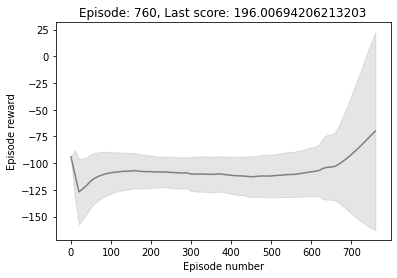

In [ ]:
# training loop for TD3

agent = Agent(alpha=0.001, beta=0.001, input_shape=env.observation_space.shape,
				n_actions=env.action_space.shape[0], tau=0.005,  env=env,
				name="BipedalWalker-v3")

best_score = env.reward_range[0]
score_history = []
plot_data = []
log_f = open("agent-log.txt","w+")
n_games = 1010


device = agent.get_device()
print("Device is : ", device)

for i in range(n_games):
    obs = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_memory(obs, action, reward, obs_, done)
        agent.learn()
        obs = obs_
        ep_reward += reward

		# env.render()

    score_history.append(ep_reward)
    avg_score = np.mean(score_history[-100:])

    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    ep_reward = 0

    # if avg_score > best_score:
    #     best_score = avg_score
        # agent.save()


    if i % plot_interval == 0:
        plot_data.append([i, np.array(score_history).mean(), np.array(score_history).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.title(f'Episode: {i}, Last score: {score}')
        plt.show()
        disp.clear_output(wait=True)

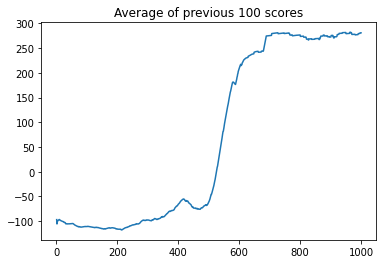

In [ ]:
avg = np.zeros(len(score_history))
for i in range(len(avg)):
    avg[i] = np.mean(score_history[max(0, i-100):(i+1)])
x = [i+1 for i in range(n_games)]
plt.plot(x, avg)
plt.title('Reward vs Episode')
plt.show()

FORK

In [ ]:
# Use this if you're on colab and want to download files
from google.colab import files

In [ ]:
# training loop for FORK

# in the submission please use seed 42 for verification
seed = 42
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)


agent = Agent(alpha=0.001, beta=0.001, delta=0.001, input_shape=env.observation_space.shape,
				n_actions=env.action_space.shape[0], sys_weight=0.5, sys_weight2=0.4,
                sys_threshold=0.02, tau=0.005,  env=env,
				name="BipedalWalker-v3")

best_score = env.reward_range[0]
score_history = []
plot_data = []
log_f = open("agent-log.txt","w+")
n_games = 1010


device = agent.get_device()
print("Device is : ", device)

for episode in range(n_games):
    obs = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_memory(obs, action, reward, obs_, done)
        agent.learn()
        obs = obs_
        ep_reward += reward

        agent.obs_lower_bound = np.amin(obs) if agent.obs_lower_bound > np.amin(obs) else agent.obs_lower_bound
        agent.obs_upper_bound = np.amax(obs) if agent.obs_lower_bound < np.amax(obs) else agent.obs_upper_bound
        agent.rew_lower_bound = (reward) if agent.rew_lower_bound > reward else agent.rew_lower_bound
        agent.rew_upper_bound = (reward) if agent.rew_upper_bound < reward else agent.rew_upper_bound

		# env.render()

    score_history.append(ep_reward)
    avg_score = np.mean(score_history[-100:])

    log_f.write('episode: {}, reward: {}\n'.format(episode, ep_reward))
    log_f.flush()
    

    # # Uncomment if you want to download files whilst running on colab
    # if avg_score > best_score:
    #     best_score = avg_score
    #     agent.save()
        # files.download('saves//BipedalWalker-v3/actor')
        # files.download('saves/BipedalWalker-v3/critic_1')
        # files.download('saves/BipedalWalker-v3/critic_2')
        # files.download('saves/BipedalWalker-v3/target_actor')
        # files.download('saves/BipedalWalker-v3/target_critic_1')
        # files.download('saves/BipedalWalker-v3/target_critic_2')
        # files.download('saves/BipedalWalker-v3/system')
        # files.download('saves/BipedalWalker-v3/sysreward')


    if episode % plot_interval == 0:
        plot_data.append([episode, np.array(score_history).mean(), np.array(score_history).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.title(f'Episode: {episode}, Last Reward: {ep_reward}')
        plt.show()
        disp.clear_output(wait=True)
        plt.savefig('Reward.png', dpi=300)
        # files.download('Reward.png')
        # files.download('agent-log.txt')

    ep_reward = 0

files.download('agent-log.txt')
files.download('Reward.png')

---

Now for the hardcore environment ...

In [ ]:
%%capture
env = gym.make("BipedalWalkerHardcore-v3")
# env = gym.make("Pendulum-v0") # useful continuous environment for quick experiments
env = gym.make("BipedalWalkerHardcore-v3")
env = gym.wrappers.Monitor(env, "./videoHC", video_callable=lambda ep_id: ep_id%video_every == 0, force=True)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

In [ ]:
print('The environment has {} observations and the agent can take {} actions'.format(obs_dim, act_dim))
print('The device is: {}'.format(device))

if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

The environment has 24 observations and the agent can take 4 actions
The device is: cpu


In [ ]:
agent = Agent(alpha=0.001, beta=0.001, delta=0.001, input_shape=env.observation_space.shape,
				n_actions=env.action_space.shape[0], sys_weight=0.5, sys_weight2=0.4,
                sys_threshold=0.02, tau=0.005,  env=env,
				name="BipedalWalker-v3")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


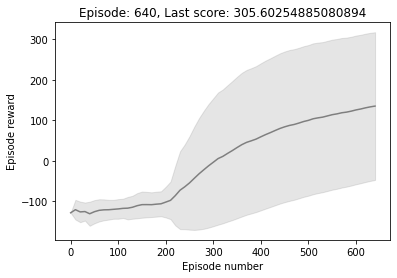

In [ ]:
# training loop

best_score = env.reward_range[0]
score_history = []
plot_data = []
log_f = open("agent-log.txt","w+")
n_games = 1010


device = agent.get_device()
print("Device is : ", device)

for i in range(n_games):
    obs = env.reset()
    done = False
    ep_reward = 0

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        agent.store_memory(obs, action, reward, obs_, done)
        agent.learn()
        obs = obs_
        ep_reward += reward

        agent.obs_lower_bound = np.amin(obs) if agent.obs_lower_bound > np.amin(obs) else agent.obs_lower_bound
        agent.obs_upper_bound = np.amax(obs) if agent.obs_lower_bound < np.amax(obs) else agent.obs_upper_bound
        agent.rew_lower_bound = (reward) if agent.rew_lower_bound > reward else agent.rew_lower_bound
        agent.rew_upper_bound = (reward) if agent.rew_upper_bound < reward else agent.rew_upper_bound

		# env.render()

    score_history.append(ep_reward)
    avg_score = np.mean(score_history[-100:])

    log_f.write('episode: {}, reward: {}\n'.format(i, ep_reward))
    log_f.flush()

    # if avg_score > best_score:
    #     best_score = avg_score
        # agent.save()


    if i % plot_interval == 0:
        plot_data.append([i, np.array(score_history).mean(), np.array(score_history).std()])
        reward_list = []
        # plt.rcParams['figure.dpi'] = 100
        plt.plot([x[0] for x in plot_data], [x[1] for x in plot_data], '-', color='tab:grey')
        plt.fill_between([x[0] for x in plot_data], [x[1]-x[2] for x in plot_data], [x[1]+x[2] for x in plot_data], alpha=0.2, color='tab:grey')
        plt.xlabel('Episode number')
        plt.ylabel('Episode reward')
        plt.title(f'Episode: {i}, Last score: {ep_reward}')
        plt.show()
        disp.clear_output(wait=True)

In [ ]:
avg = np.zeros(len(score_history))
for i in range(len(avg)):
    avg[i] = np.mean(score_history[max(0, i-100):(i+1)])
x = [i+1 for i in range(n_games)]
plt.plot(x, avg)
plt.title('Reward vs Episode')
plt.show()

In [ ]:
env.close()